# WeatherPy
----

## Three observable trends for this data set include:
1. There is a strong correlation between an increase in temperature and how close we are to the equator (0 latitude). This is true both in the Northern and Southern Hemisphere as the r-values are inverse (one graph has a strong negative correlation with temperature as we get further away from the equator and one graph has a strong positive correlation with temperature we get closer to the equator).
2. There is a weak positive correlation between cloudiness percent and latitude.
3. No relationship between latitude and wind speed can be confidently observed from this data set.


In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os
import csv
from datetime import datetime #for converting Unix UTC datetime to human-readable date

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [5]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

649

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [6]:
api = weather_api_key
# Build query URL
url = "http://api.openweathermap.org/data/2.5/weather?"

def APIRequest(cityNumber):#function for making the API call to OpenWeatherMap.org and returning the data
    query_url = url + "appid=" + api + "&q=" + cities[cityNumber-1] + "&units=imperial"
    responseJson = requests.get(query_url).json() #making the API request and grabbing the JSON from the response

    if ("'message': 'city not found'" in str(responseJson)): #checking response JSON for the string of text containing the message 'city not found'
        full_City_Data.append("NaN")#if the city is not found, append a NaN value (makes dropping items with pandas easier later) to the lists to keep the index numbers correct
        city_City_Data.append("NaN")#list for city names
        lat_City_Data.append("NaN")#list for city latitude
        lng_City_Data.append("NaN")#list for city longitude
        max_Temp_City_Data.append("NaN")#list for city maximum temperature
        humidity_City_Data.append("NaN")#list for city humidity
        cloudiness_City_Data.append("NaN")#list for city cloudiness amount
        wind_Speed_City_Data.append("NaN")#list for city wind speed amount
        country_City_Data.append("NaN")#list for which country a city is in
        date_City_Data.append("NaN")#list for the datetime information stored in unix UTC format
        print("City not found. Skipping...")
    else:
        full_City_Data.append(responseJson) #if the city is found, do append the information to the lists
        city_City_Data.append(responseJson["name"])
        lat_City_Data.append(responseJson["coord"]["lat"])
        lng_City_Data.append(responseJson["coord"]["lon"])
        max_Temp_City_Data.append(responseJson["main"]["temp_max"])
        humidity_City_Data.append(responseJson["main"]["humidity"])
        cloudiness_City_Data.append(responseJson["clouds"]["all"])
        wind_Speed_City_Data.append(responseJson["wind"]["speed"])
        country_City_Data.append(responseJson["sys"]["country"])
        date_City_Data.append(responseJson["dt"])
        #convert the datetime in unix UTC format to human-readable format. I only need one not null value from this list; all API calls are made on the same date
        converted_Date.append(datetime.utcfromtimestamp(responseJson["dt"]).strftime('%m-%d-%Y')) #only in the else block to prevent null values

#if length of cities is exactly divisible by 50 then get the length. else we need to add an extra batch to account for the remainder
remainder = 0
if (len(cities) % 50 == 0):
        totalBatches = int(len(cities) / 50) #doing batches of 50 API calls at once; finding the total number of batches I will be making
else:
    totalBatches = int((len(cities) / 50)+1)
    remainder = int(len(cities) % 50)
    
batchCounter = 1
requestsPerBatch = 50
requestCounter = 1
cityNumber = 1
#creating empty lists to use to append each piece of the weather data response to
full_City_Data, city_City_Data, lat_City_Data, lng_City_Data, max_Temp_City_Data, humidity_City_Data, cloudiness_City_Data, wind_Speed_City_Data, country_City_Data, date_City_Data, converted_Date = [], [], [], [], [], [], [], [], [], [], []

print("Beginning Data Retrieval\n-----------------------------")
while (batchCounter <= totalBatches): 
    print(f"Starting batch {batchCounter} of {totalBatches}.")
    while ((batchCounter != totalBatches) & (requestCounter <= requestsPerBatch)): #if we're not on the final batch, run this code
        cityNumber = (50 * (batchCounter-1)) + requestCounter #calculating city number        
        APIRequest(cityNumber)
        if (city_City_Data[cityNumber-1] != "NaN"):#if any of lists at this element are blank, skip printing the name and move onto the next city
            print(f"Request {requestCounter} of batch {batchCounter}. City number: {cityNumber} City name: {city_City_Data[cityNumber-1]}.")
        requestCounter +=1
    while ((batchCounter == totalBatches) & (requestCounter <= remainder)): #if we are on the final batch, run this code
        cityNumber = (50 * (batchCounter-1)) + requestCounter #calculating city number
        APIRequest(cityNumber)
        if (city_City_Data[cityNumber-1] != "NaN"):#if any of lists at this element are blank, skip printing the name and move onto the next city
            print(f"Request {requestCounter} of batch {batchCounter}. City number: {cityNumber} City name: {city_City_Data[cityNumber-1]}.")
        requestCounter +=1        
    batchCounter +=1
    requestCounter = 1 #resetting requestCounter so it will hit the inner while loop again in the next iteration of the outer while loop
    #break; ##break out early for making testing faster##
    
print("-----------------------------\nData Retrieval Complete\n----------------------------") 

Beginning Data Retrieval
-----------------------------
Starting batch 1 of 13.
Request 1 of batch 1. City number: 1 City name: Hithadhoo.
City not found. Skipping...
Request 3 of batch 1. City number: 3 City name: Punta Arenas.
Request 4 of batch 1. City number: 4 City name: Lipari.
Request 5 of batch 1. City number: 5 City name: Taltal.
Request 6 of batch 1. City number: 6 City name: Port Alfred.
Request 7 of batch 1. City number: 7 City name: Ushuaia.
Request 8 of batch 1. City number: 8 City name: Ponta Delgada.
Request 9 of batch 1. City number: 9 City name: Cape Town.
Request 10 of batch 1. City number: 10 City name: Kaitangata.
Request 11 of batch 1. City number: 11 City name: Bluff.
Request 12 of batch 1. City number: 12 City name: Kapaa.
Request 13 of batch 1. City number: 13 City name: Airai.
Request 14 of batch 1. City number: 14 City name: São Gabriel da Cachoeira.
Request 15 of batch 1. City number: 15 City name: Albany.
Request 16 of batch 1. City number: 16 City name: Ait

Request 42 of batch 3. City number: 142 City name: Bengkulu.
Request 43 of batch 3. City number: 143 City name: Saint George.
Request 44 of batch 3. City number: 144 City name: Vieques.
Request 45 of batch 3. City number: 145 City name: Dibulla.
Request 46 of batch 3. City number: 146 City name: Antalaha.
Request 47 of batch 3. City number: 147 City name: Port Hedland.
Request 48 of batch 3. City number: 148 City name: Ladário.
City not found. Skipping...
Request 50 of batch 3. City number: 150 City name: Sioux Lookout.
Starting batch 4 of 13.
Request 1 of batch 4. City number: 151 City name: Sibolga.
City not found. Skipping...
Request 3 of batch 4. City number: 153 City name: Qaanaaq.
Request 4 of batch 4. City number: 154 City name: Port Macquarie.
Request 5 of batch 4. City number: 155 City name: Saskylakh.
Request 6 of batch 4. City number: 156 City name: Lewistown.
Request 7 of batch 4. City number: 157 City name: Vāsudevanallūr.
Request 8 of batch 4. City number: 158 City name: 

Request 34 of batch 6. City number: 284 City name: Port Elizabeth.
Request 35 of batch 6. City number: 285 City name: Tiksi.
Request 36 of batch 6. City number: 286 City name: Nanchong.
Request 37 of batch 6. City number: 287 City name: Lokosovo.
Request 38 of batch 6. City number: 288 City name: Rawson.
Request 39 of batch 6. City number: 289 City name: Trincomalee.
Request 40 of batch 6. City number: 290 City name: Mana.
Request 41 of batch 6. City number: 291 City name: Faanui.
Request 42 of batch 6. City number: 292 City name: Porosozero.
City not found. Skipping...
Request 44 of batch 6. City number: 294 City name: Kvam.
Request 45 of batch 6. City number: 295 City name: Nyandoma.
Request 46 of batch 6. City number: 296 City name: Bushehr.
Request 47 of batch 6. City number: 297 City name: Carácuaro.
Request 48 of batch 6. City number: 298 City name: Rio Grande.
Request 49 of batch 6. City number: 299 City name: San Patricio.
Request 50 of batch 6. City number: 300 City name: Soro

City not found. Skipping...
Request 22 of batch 9. City number: 422 City name: Fortuna.
Request 23 of batch 9. City number: 423 City name: Murray Bridge.
Request 24 of batch 9. City number: 424 City name: Berja.
Request 25 of batch 9. City number: 425 City name: Banda Aceh.
City not found. Skipping...
Request 27 of batch 9. City number: 427 City name: Bodden Town.
Request 28 of batch 9. City number: 428 City name: Kenai.
Request 29 of batch 9. City number: 429 City name: Manono.
Request 30 of batch 9. City number: 430 City name: Alice Springs.
Request 31 of batch 9. City number: 431 City name: San Rafael.
Request 32 of batch 9. City number: 432 City name: Boryslav.
Request 33 of batch 9. City number: 433 City name: Lagos.
Request 34 of batch 9. City number: 434 City name: Muravlenko.
City not found. Skipping...
Request 36 of batch 9. City number: 436 City name: Natal.
Request 37 of batch 9. City number: 437 City name: Jumla.
Request 38 of batch 9. City number: 438 City name: Shelburne.

Request 12 of batch 12. City number: 562 City name: Leningradskiy.
Request 13 of batch 12. City number: 563 City name: Borba.
Request 14 of batch 12. City number: 564 City name: Black River.
Request 15 of batch 12. City number: 565 City name: Grójec.
Request 16 of batch 12. City number: 566 City name: Deputatsky.
Request 17 of batch 12. City number: 567 City name: Oodweyne.
Request 18 of batch 12. City number: 568 City name: Arlit.
City not found. Skipping...
Request 20 of batch 12. City number: 570 City name: San Quintín.
Request 21 of batch 12. City number: 571 City name: Allada.
Request 22 of batch 12. City number: 572 City name: Anadyr.
Request 23 of batch 12. City number: 573 City name: Zhezkazgan.
Request 24 of batch 12. City number: 574 City name: Moratuwa.
Request 25 of batch 12. City number: 575 City name: Amapá.
Request 26 of batch 12. City number: 576 City name: Mhango.
Request 27 of batch 12. City number: 577 City name: Kuminskiy.
Request 28 of batch 12. City number: 578 Ci

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
#use each individual list as a column in the data frame
weather_df = pd.DataFrame(data={"City": city_City_Data, "Lat": lat_City_Data, "Lng": lng_City_Data, "Max Temp": max_Temp_City_Data, "Humidity": humidity_City_Data, "Cloudiness": cloudiness_City_Data, "Wind Speed": wind_Speed_City_Data, "Country": country_City_Data, "Date": date_City_Data})

output_path = os.path.join("Output", "output.csv")
weather_df.to_csv(output_path, sep=',',index=False)#write the data frame to a CSV

weather_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Hithadhoo,-0.6,73.08,81.95,68,1,8.46,MV,1608104898
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Punta Arenas,-53.15,-70.92,48.2,61,0,44.96,CL,1608104898
3,Lipari,38.47,14.95,54,93,75,2.55,IT,1608104898
4,Taltal,-25.4,-70.48,59.65,79,62,1.12,CL,1608104898


In [8]:
cleaned_weather_df = weather_df.drop(columns=["City", "Country"]) #drop the non-numeric data from the data frame
#convert all columns to floats so I can drop the NaN values with pandas
cleaned_weather_df[["Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed", "Date"]] = cleaned_weather_df[["Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed", "Date"]].astype(float)
cleaned_weather_df.dropna(axis=0,how='all', inplace=True)#drop all NaN items from data frame

cleaned_weather_df.describe() #summarize the remaining numeric data

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,5.930000e+02
mean,21.308128,19.733963,51.783002,73.188870,55.080944,8.382850,1.608105e+09
std,31.820063,88.239061,30.680341,21.516997,40.093264,6.549487,6.263303e+01
min,-54.800000,-179.170000,-47.020000,2.000000,0.000000,0.180000,1.608104e+09
25%,-1.400000,-56.320000,30.200000,63.000000,4.000000,3.910000,1.608105e+09
50%,22.830000,22.680000,61.000000,79.000000,75.000000,6.710000,1.608105e+09
75%,47.800000,97.200000,76.710000,89.000000,92.000000,11.410000,1.608105e+09
max,78.220000,178.420000,102.990000,100.000000,100.000000,49.440000,1.608105e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [9]:
# no cities had a humidity of over 100%.

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

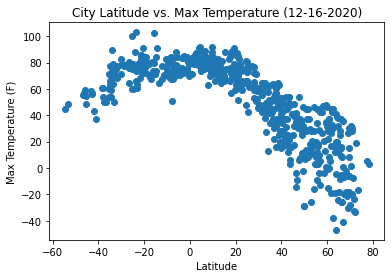

In [10]:
image_output_path = os.path.join("Output", "Images", "LatVsTemp.png")
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Max Temp"])
plt.title(f"City Latitude vs. Max Temperature ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig(image_output_path)
plt.show()

This graph is analyzing the relationship between the max temperature (in Fahrenheit) a city got to compared to the latitude of that city.

## Latitude vs. Humidity Plot

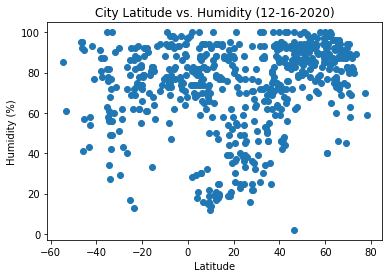

In [11]:
image_output_path = os.path.join("Output", "Images", "LatVsHumidity.png")
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Humidity"])
plt.title(f"City Latitude vs. Humidity ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig(image_output_path)
plt.show()

This graph is analyzing the relationship between the humidity (measured in percent humidity) a city got to compared to the latitude of that city.

## Latitude vs. Cloudiness Plot

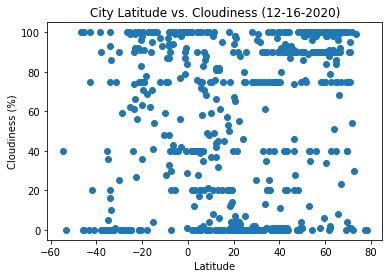

In [12]:
image_output_path = os.path.join("Output", "Images", "LatVsCloudiness.png")
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Cloudiness"])
plt.title(f"City Latitude vs. Cloudiness ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig(image_output_path)
plt.show()

This graph is analyzing the relationship between how cloudy the weather in a city is (measured in percent cloudiness) compared to the latitude of that city. 0 cloudiness represents completely clear skies.

## Latitude vs. Wind Speed Plot

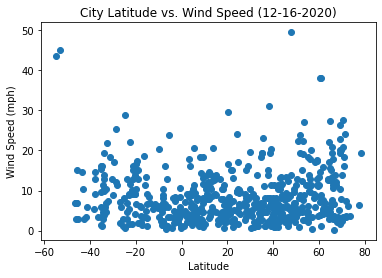

In [13]:
image_output_path = os.path.join("Output", "Images", "LatVsWindSpeed.png")
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Wind Speed"])
plt.title(f"City Latitude vs. Wind Speed ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig(image_output_path)
plt.show()

This graph is analyzing the relationship between wind speed (measured in miles per hour) in a city compared to the latitude of that city. 

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

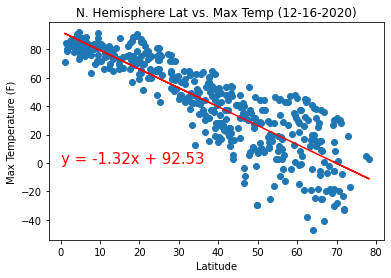

The r-value is: -0.8686277192353992


In [14]:
image_output_path = os.path.join("Output", "Images", "NorthLatVsTemp.png")
#check to see if the latitude is greater than or equal to 0 degrees; if so, then the city must be in the northern hemisphere

#make a copy of the original data frame before I drop any NaN values because if I set the second data frame equal 
#to the first (without copy) then they will point to the same object in memory and drop items from the original data frame!
northern_hemisphere_df = cleaned_weather_df.copy()
northern_hemisphere_df['Lat'] = northern_hemisphere_df[northern_hemisphere_df['Lat'] >= 0]
northern_hemisphere_df.dropna(axis=0,how='any', inplace=True) #removing any of the cities that are in the southern hemisphere

(slope, intercept, rvalue, pvalue, stderr) = linregress(northern_hemisphere_df["Lat"], northern_hemisphere_df["Max Temp"]) #extracting values for the linear regression model
regress_values = northern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(northern_hemisphere_df["Lat"], northern_hemisphere_df["Max Temp"]) #creating the initial scatter plot
plt.plot(northern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(0,0),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (0,0) on the chart

plt.title(f"N. Hemisphere Lat vs. Max Temp ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

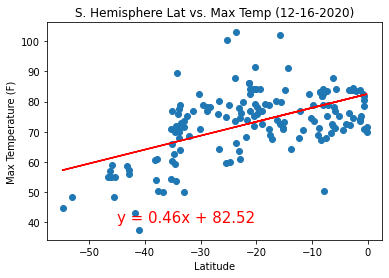

The r-value is: 0.5530356762434977


In [15]:
image_output_path = os.path.join("Output", "Images", "SouthLatVsTemp.png")
#check to see if the latitude is less than 0 degrees; if so, then the city must be in the southern hemisphere

#make a copy of the original data frame as to not modify the original data
southern_hemisphere_df = cleaned_weather_df.copy()
southern_hemisphere_df['Lat'] = southern_hemisphere_df[southern_hemisphere_df['Lat'] < 0]
southern_hemisphere_df.dropna(axis=0,how='any', inplace=True) #removing any of the cities that are in the northern hemisphere

(slope, intercept, rvalue, pvalue, stderr) = linregress(southern_hemisphere_df["Lat"], southern_hemisphere_df["Max Temp"]) #extracting values for the linear regression model
regress_values = southern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(southern_hemisphere_df["Lat"], southern_hemisphere_df["Max Temp"]) #creating the initial scatter plot
plt.plot(southern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(-45,40),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (-45,40) on the chart

plt.title(f"S. Hemisphere Lat vs. Max Temp ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

This linear regression is modeling the relationship between latitude and max temperature. There is a strong positive correlation  with temperature as the latitude on each graph gets closer to 0 latitude (the equator). 

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

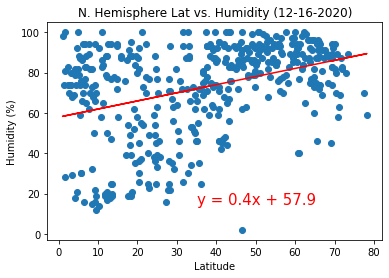

The r-value is: 0.3685390394913572


In [16]:
image_output_path = os.path.join("Output", "Images", "NorthLatVsHumidity.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(northern_hemisphere_df["Lat"], northern_hemisphere_df["Humidity"]) #extracting values for the linear regression model
regress_values = northern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(northern_hemisphere_df["Lat"], northern_hemisphere_df["Humidity"]) #creating the initial scatter plot
plt.plot(northern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(35,15),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (35,15) on the chart

plt.title(f"N. Hemisphere Lat vs. Humidity ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

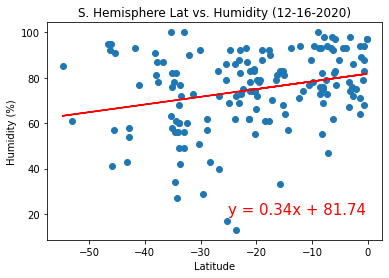

The r-value is: 0.2642638414529233


In [17]:
image_output_path = os.path.join("Output", "Images", "SouthLatVsHumidity.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(southern_hemisphere_df["Lat"], southern_hemisphere_df["Humidity"]) #extracting values for the linear regression model
regress_values = southern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(southern_hemisphere_df["Lat"], southern_hemisphere_df["Humidity"]) #creating the initial scatter plot
plt.plot(southern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(-25,20),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (-25,20) on the chart

plt.title(f"S. Hemisphere Lat vs. Humidity ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

This linear regression is modeling the relationship between latitude and humidity. There is a weak positive correlation with percent humidity as the latitude on each graph gets larger.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

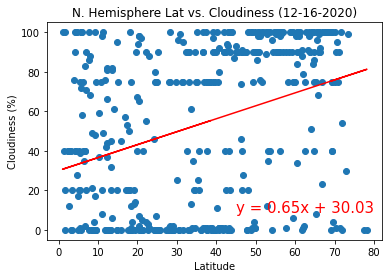

The r-value is: 0.33991463043822806


In [18]:
image_output_path = os.path.join("Output", "Images", "NorthLatVsCloudiness.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(northern_hemisphere_df["Lat"], northern_hemisphere_df["Cloudiness"]) #extracting values for the linear regression model
regress_values = northern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(northern_hemisphere_df["Lat"], northern_hemisphere_df["Cloudiness"]) #creating the initial scatter plot
plt.plot(northern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(45,9),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (45,9) on the chart

plt.title(f"N. Hemisphere Lat vs. Cloudiness ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

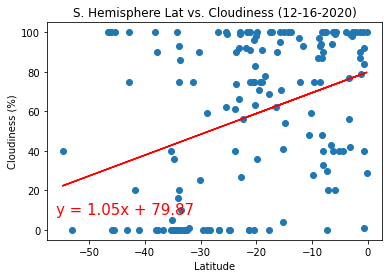

The r-value is: 0.35926831200380005


In [19]:
image_output_path = os.path.join("Output", "Images", "SouthLatVsCloudiness.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(southern_hemisphere_df["Lat"], southern_hemisphere_df["Cloudiness"]) #extracting values for the linear regression model
regress_values = southern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(southern_hemisphere_df["Lat"], southern_hemisphere_df["Cloudiness"]) #creating the initial scatter plot
plt.plot(southern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(-56,8),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (-56,8) on the chart

plt.title(f"S. Hemisphere Lat vs. Cloudiness ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

This linear regression is modeling the relationship between latitude and cloudiness. There is a weak positive correlation with percent cloudiness as the latitude on each graph gets larger.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

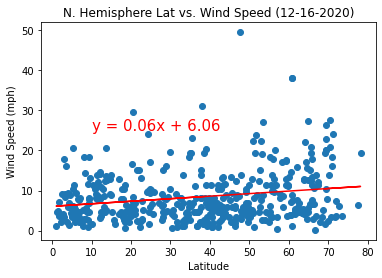

The r-value is: 0.2070144508710242


In [20]:
image_output_path = os.path.join("Output", "Images", "NorthLatVsWindSpeed.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(northern_hemisphere_df["Lat"], northern_hemisphere_df["Wind Speed"]) #extracting values for the linear regression model
regress_values = northern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(northern_hemisphere_df["Lat"], northern_hemisphere_df["Wind Speed"]) #creating the initial scatter plot
plt.plot(northern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(10,25),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (10,25) on the chart

plt.title(f"N. Hemisphere Lat vs. Wind Speed ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

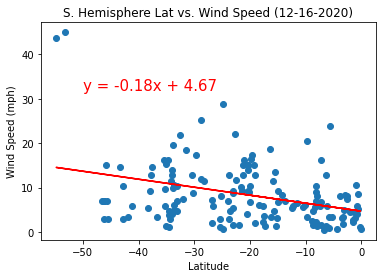

The r-value is: -0.34835359167270946


In [21]:
image_output_path = os.path.join("Output", "Images", "SouthLatVsWindSpeed.png")
(slope, intercept, rvalue, pvalue, stderr) = linregress(southern_hemisphere_df["Lat"], southern_hemisphere_df["Wind Speed"]) #extracting values for the linear regression model
regress_values = southern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(southern_hemisphere_df["Lat"], southern_hemisphere_df["Wind Speed"]) #creating the initial scatter plot
plt.plot(southern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(-50,32),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (-50,32) on the chart

plt.title(f"S. Hemisphere Lat vs. Wind Speed ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig(image_output_path)
plt.show()

print(f"The r-value is: {rvalue}")

This linear regression is modeling the relationship between latitude and wind speed in miles per hour. No relationship between latitude and wind speed can be confidently observed from this data set.